# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Первичное ознакомление с данными

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [13]:

df = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')

In [14]:
data = df.copy()
display(data.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


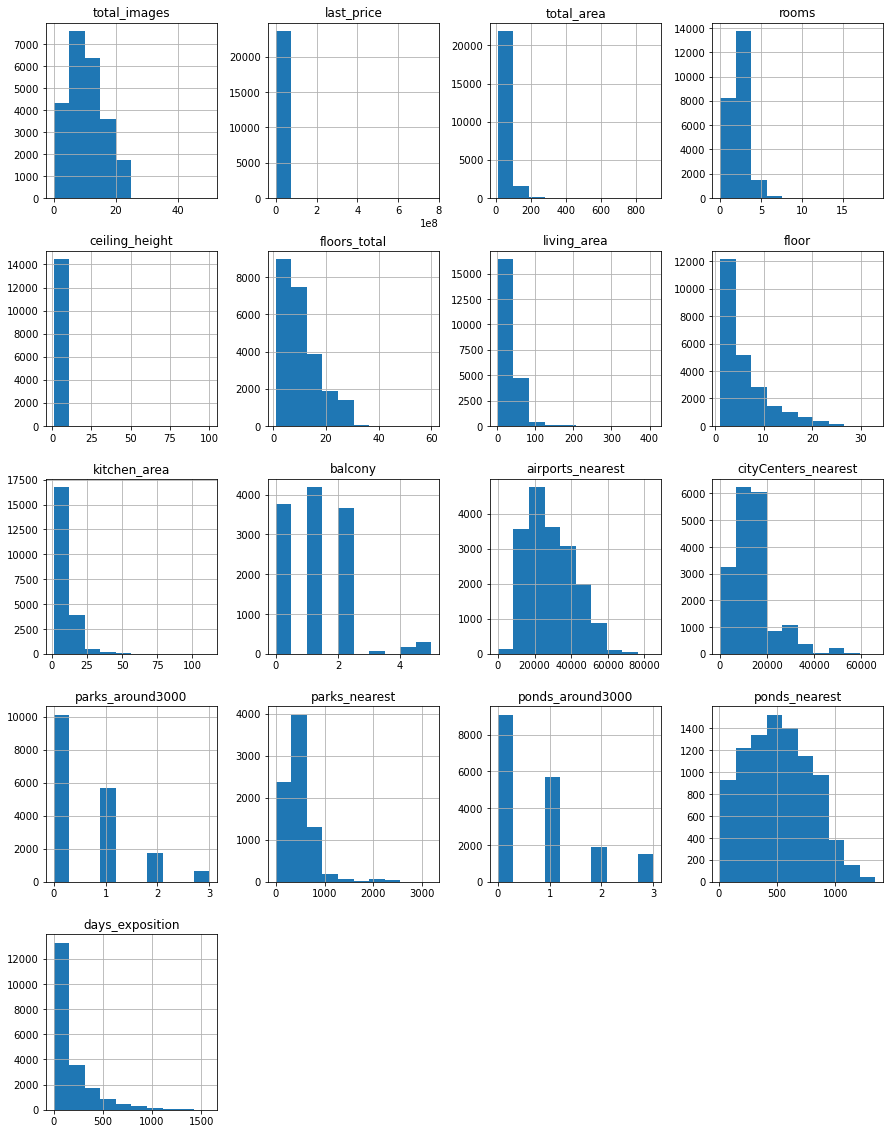

In [15]:
data.hist(figsize=(15, 20));

Предварительная оценка данных показала, что распределения значений по факторам не соответствует нормальному (имеются выбросы), в данных имеются пропуски, тип данных требует корректировки

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Предобработка данных

In [17]:
#Переименуем столбцы, чтобы они соответствовали змеиному регистру
data = data.rename(columns={'cityCenters_nearest':'city_сenters_nearest', 'parks_around3000':'parks_around_3000', 'ponds_around3000':'ponds_around_3000'})

### Исследование и заполнение пропусков в данных

In [18]:
#определим количество пропущенных значений для каждого столбца
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_сenters_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В столбцах имеются <b>пропущенные значения</b>. <p>"ceiling_height" - сравним 2 варианта заполнения и выберем оптимальный: заполним медианным значением, где возможно, исходя из стоимости 1 кв.м. и заполнение медианным значением по столбцу  <p>"floors_total" - пропущенных значений всего 0,36% от общих данных, эти данные исключим из исследования <p>"living_area" - заполним пропуски медианным значением, в зависимости от количество комнат <p>"is_apartment" - предположим, что там, где значения пропущены, это не аппартаменты, заполним значением False<p>"kitchen_area" - проверим 2 теории:заполним медианным значением относительно общей площади и в процентном отношении доли кухни<p>"balcony" - предположим, что пропущенные значения соответствуют отсутствию балконов <p>"locality_name" - на значение 'неизвестно'<p>"airports_nearest" - заполним максимальным значением <p>"city_сenters_nearest" - заполним максимальным значением <p>"parks_around_3000" - заполним значением 0, так, как при наличии парка, скорее всего указали бы <p>"parks_nearest" - так как наличие парков является преимуществом для недвижимости, если бы они были по-близости, скорее всего, данные о них были бы указано, в всязи с чем, предположим, что по-близости парков нет, заполним пропуски значением максимальным, среди имеющихся <p>"ponds_around_3000" - заполним значением 0 <p>"ponds_nearest"- тоже самое, что и с парками - заполним максимальным значением <p>"days_exposition" - пока оставим, для дальнейшего исследования


Можем предположить, что стоимость недвижимости зависит от общей площади, а также, высоты потолков, проведем группировку по цене за квадратный метр и заполним пропуски значений высоты потолков медианным значением 

In [19]:
# Добавляем столбец со стоимостью квадратного метра 
data['cost_per_square_meter'] = data['last_price'] / data['total_area']

#Заполним пропущенные значения ceiling_height медианным
ceiling_height_to_fill = data.groupby('cost_per_square_meter')['ceiling_height'].transform('median')
data['ceiling_height_cost_per_square_meter'] = data['ceiling_height'].fillna(ceiling_height_to_fill)

In [20]:
data['ceiling_height_cost_per_square_meter'].describe()

count    18410.000000
mean         2.756636
std          1.173160
min          1.000000
25%          2.540000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height_cost_per_square_meter, dtype: float64

Также сравним полученные значения, при условии заполнения медианным значением по стобцу

In [21]:
#Заполним пропущенные значения ceiling_height медианным
ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height_median'] = data['ceiling_height'].fillna(ceiling_height_median)
data['ceiling_height_median'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height_median, dtype: float64

Так как стандартное отклонение меньше во втором случе ( 0.988298 против 1.173160), то остановимся на заполнении пропусков медианным значением

In [22]:
data['ceiling_height'] = data['ceiling_height_median']

Так как, столбец "floors_total" содержит всего 86 пропущенных значений, что составляет меньше 0,36%, исключим эти значения из исследования

In [23]:
#Удалим пропущенные значения столбца 'floors_total'
data.dropna(subset=['floors_total'], inplace=True)

In [24]:
#Заполним пропуски стобца'locality_name' на значение 'неизвестно'
data['locality_name']= data['locality_name'].fillna('неизвестно')

In [25]:
#Заполним пропущенные значения столбца 'balcony' на 0
data['balcony'] = data['balcony'].fillna(0)

In [26]:
#Заполним пропущенные значения столбца 'is_apartment' на False
data['is_apartment'] = data['is_apartment'].fillna(value=False)

In [27]:
#Заполним пропущенные значения столбца 'city_сenters_nearest' максимальным значением из имеющихся
data['city_сenters_nearest'] = data['city_сenters_nearest'].fillna(data['city_сenters_nearest'].max())

In [28]:
#Заполним пропущенные значения столбца 'airports_nearest' максимальным значением из имеющихся
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].max())

In [29]:
#Заполним пропущенные значения столбца 'parks_nearest' максимальным значением из имеющихся
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].max())

In [30]:
#Заполним пропущенные значения столбца 'ponds_nearest' максимальным значением из имеющихся
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].max())

In [31]:
# Заменяем пропущенные значения в столбце количество парков в радиусе 3000м на 0
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)

In [32]:
# Заменяем пропущенные значения в столбце количество водоемов в радиусе 3000м на 0
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_year'] = data['first_day_exposition'].dt.year
data[data['days_exposition'].isnull()].pivot_table(columns = 'first_day_year', values = 'total_area', aggfunc = 'count')

first_day_year,2014,2015,2016,2017,2018,2019
total_area,18,70,67,271,958,1788


Если рассматривать распределение пропусков относительно года выставления на продажу, можно заметить, что большая часть пропущенных значений - в 2019 году. Больше половины объектов, выставленных на продажу в 2019 году не имеет рассчитанного "времени продажи квартиры". Также высокая доля пропусков, хотя и меньшая - в 2018 году. Получается, чем свежей объявление - тем выше вероятность пропуска в этой колонке. 

Пропуск в этой колонке означает, что объект не продан и объявление не закрыто. Поэтому заполнять пропуски в этом столбце не надо - они не случайные и существенно влияют на статистику.

Рассмотрим факторы, влияющие на жилую площадь: количество комнат, площадь кухни, цена, общая площадь 

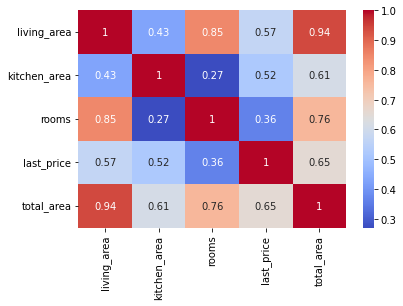

In [34]:
corr_living_area = data.loc[:, ['living_area', 'kitchen_area','rooms','last_price','total_area']]

sns.heatmap(corr_living_area.corr(), annot = True, cmap= 'coolwarm');

Исходя из значения коэффициента Пирсона (0,94), наибольшая зависимость между жилой и общей площадью недвижимости 

In [35]:
#Заполним пропуски медианным значением в соответствии с общей площадью
living_area_to_fill = data.groupby('total_area')['living_area'].transform('median')
data['living_area'] = data['living_area'].fillna(living_area_to_fill)

Рассмотрим факторы, влияющие на значения площади кухни, относительно количества комнат, ценой, общей и жилой площадью недвижимости

Так как коэффициент Пирсона выше в паре площадь кухни - общая площадь(0,61), то возьмем за основу ее

In [36]:
#Заполним пропуски медианным значением в соответствии с общей площадью
kitchen_area_to_fill = data.groupby('total_area')['kitchen_area'].median()
data['kitchen_area_median'] = data['kitchen_area'].fillna(kitchen_area_to_fill)

In [37]:
data['kitchen_area_median'].describe()

count    21400.000000
mean        10.570055
std          5.911212
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area_median, dtype: float64

Исследуем вариант 2:

In [38]:
#Определим среднее значение доли кухни
kitchen_area_part = (data['kitchen_area']/data['total_area']).mean()

#Заполним пропуски исходя из доли кухни в общей площади
data['kitchen_area_part'] = data['kitchen_area'].fillna(kitchen_area_part*data['total_area'])

data['kitchen_area_part'].describe()

count    23613.000000
mean        10.568630
std          6.095654
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area_part, dtype: float64

Стандартное отклонение во первом варианте меньше (5.911212 против 6.095724), остановимся на первом варианте (заполнение пропусков используя медианное значение)

In [39]:
#Перезапишем значения столбца
data['kitchen_area'] = data['kitchen_area_median']

In [40]:
#Удалим явные дубликаты
data = data.drop_duplicates()

In [41]:
#Проверим, остались ли пропущенные значения 
data.isna().sum()

total_images                               0
last_price                                 0
total_area                                 0
first_day_exposition                       0
rooms                                      0
ceiling_height                             0
floors_total                               0
living_area                              133
floor                                      0
is_apartment                               0
studio                                     0
open_plan                                  0
kitchen_area                            2213
balcony                                    0
locality_name                              0
airports_nearest                           0
city_сenters_nearest                       0
parks_around_3000                          0
parks_nearest                              0
ponds_around_3000                          0
ponds_nearest                              0
days_exposition                         3172
cost_per_s

Было установлено, что в данных имеются пропуски в разных столбцах, часть из них, скорее всего не была указана пользователем, а часть, мы предполагаем, имеют технический характер. В ходе предобработки данных, по возможности, они были устранены.

### Изменение типов данных

In [42]:
# Приводим в целочисленный тип стоимость квартиры
data['last_price'] = data['last_price'].astype(int)

In [43]:
# Приводим этажность к целочисленному типу
data['floors_total'] = data['floors_total'].astype(int)

In [44]:
# Приводим в булевый тип данных, принадлежит ли объект апартаментам
data['is_apartment'] = data['is_apartment'].astype(bool)

In [45]:
# Приводим в целочисленный тип количество балконов
data['balcony'] = data['balcony'].astype(int)

In [46]:
# Приводим в целочисленный тип количество парков. 
data['parks_around_3000'] = data['parks_around_3000'].astype(int)

In [47]:
# Приводим в целочисленный тип количество прудов. 
data['ponds_around_3000'] = data['ponds_around_3000'].astype(int)

In [48]:
# Приводим к типу даты дату публикации
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [49]:
#Для экономии памяти, преобразуем данные с float64 на float32 общу площадь
data['total_area'] = data['total_area'].astype('float32')

In [50]:
#Для экономии памяти, преобразуем данные с float64 на float32 высоту потолков
data['ceiling_height'] = data['ceiling_height'].astype('float32')

In [51]:
#Для экономии памяти, преобразуем данные с float64 на float32 жилую площадь
data['living_area'] = data['living_area'].astype('float32')

In [52]:
#Для экономии памяти, преобразуем данные с float64 на float32 жилую площадь
data['kitchen_area'] = data['kitchen_area'].astype('float32')

В столбцах: общая площадь, высота потолков, жилая площадь и площадь кухни тип данных был изменен на float32 для экономии памяти

### Обработка неявных дубликатов

In [53]:
#Рассмотрим неявные дубликаты в столбце с названием локации
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [54]:
#Удалим неявные дубликаты, которые были выявлены
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество','садовое товарищество')
data['locality_name'] = data['locality_name'].replace('деревня Кудрово', 'Кудрово')
data['locality_name'] = data['locality_name'].replace('посeлок Мурино', 'Мурино')

In [55]:
#Проверим, чтобы неявняе дубликаты были устранены 
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

### Обработка и удаление аномалий (редких значений)

In [56]:
#изучим значения в столбце "высота потолков", чтобы исключить аномалии
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [57]:
#Значения высоты потолков больше 20 разделим на 10
data.loc[(data['ceiling_height'] > 20), 'ceiling_height'] /= 10

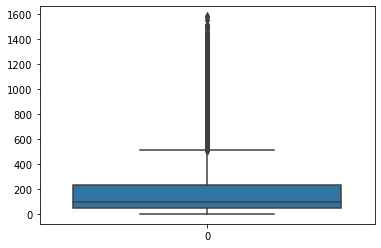

In [58]:
#Построим "Ящик с усами"
sns.boxplot(data = data['days_exposition']);

Хорошо видно, что значения больше 550 - являются выбросами, откинем их

In [59]:
#Откинем объявления, висевшие больше 550 дней
data = data[data['days_exposition']<=550]

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18978 entries, 1 to 23695
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   total_images                          18978 non-null  int64         
 1   last_price                            18978 non-null  int32         
 2   total_area                            18978 non-null  float32       
 3   first_day_exposition                  18978 non-null  datetime64[ns]
 4   rooms                                 18978 non-null  int64         
 5   ceiling_height                        18978 non-null  float32       
 6   floors_total                          18978 non-null  int32         
 7   living_area                           18871 non-null  float32       
 8   floor                                 18978 non-null  int64         
 9   is_apartment                          18978 non-null  bool          
 10

In [61]:
#Создадим функцию для определения верхней и нижней границы распределения

def det_borders(column):
    statistic = data[column].describe()
    
    # межквартильный размах
    interquartile_range = statistic[6] - statistic[4]
    
    # левая и правая граница    
    left_border = statistic[4] - 1.5 * interquartile_range
    right_border = statistic[6] + 1.5 * interquartile_range
    
    # левая граница не должна быть меньше минимального значения
    if left_border < statistic[3]: 
        left_border = statistic[3] 
        
    # правая граница не должна быть больше максимального значения
    if right_border > statistic[7]: 
        right_border = statistic[7]
    
    return [left_border, right_border]

In [62]:
det_borders('last_price')

[12190.0, 10915000.0]

In [63]:
#Создадим столбцы со слишком дорогой и слишком дешевой недвижимостью
data['last_price_too_much'] = data['last_price']>=det_borders('last_price')[1]
data['last_price_little'] = data['last_price']<=det_borders('last_price')[0]

In [64]:
det_borders('living_area')

[2.0, 75.19999885559082]

In [65]:
#Создадим столбцы со слишком большой и слишком малой жилой площадью недвижимостью
data['living_area_too_much'] = data['living_area']>=det_borders('living_area')[1]
data['living_area_little'] = data['living_area']<=det_borders('living_area')[0]

In [66]:
det_borders('total_area')

[12.0, 108.60000610351562]

In [67]:
#Создадим столбцы со слишком большой и слишком малой общей площадью недвижимостью
data['total_area_too_much'] = data['total_area']>=det_borders('total_area')[1]
data['total_area_little'] = data['total_area']<=det_borders('total_area')[0]

In [68]:
det_borders('ceiling_height')

[2.449999690055847, 2.850000262260437]

In [69]:
#Создадим столбцы со слишком высокими и слишком низкими потолками
data['ceiling_height_too_much'] = data['ceiling_height']>=det_borders('ceiling_height')[1]
data['ceiling_height_little'] = data['ceiling_height']<=det_borders('ceiling_height')[0]

In [70]:
det_borders('rooms')

[0.0, 6.0]

In [71]:
#Создадим столбцы со слишком большим и слишком малым числом комнат
data['rooms_too_much'] = data['rooms']>=det_borders('rooms')[1]
data['rooms_little'] = data['rooms']<=det_borders('rooms')[0]

In [72]:
det_borders('kitchen_area')

[2.0, 18.749999523162842]

In [73]:
#Создадим столбцы со слишком большой и слишком малой площадью кухни
data['kitchen_area_too_much'] = data['kitchen_area']>=det_borders('kitchen_area')[1]
data['kitchen_area_little'] = data['kitchen_area']<=det_borders('kitchen_area')[0]

In [74]:
det_borders('airports_nearest')

[0.0, 84869.0]

In [75]:
#Создадим столбцы со слишком далеким и слишком близким расположением от аэропорта
data['airports_nearest_too_much'] = data['airports_nearest']>=det_borders('airports_nearest')[1]
data['airports_nearest_little'] = data['airports_nearest']<=det_borders('airports_nearest')[0]

In [76]:
det_borders('city_сenters_nearest')

[208.0, 65968.0]

In [77]:
#Создадим столбцы со слишком далеким и слишком близким расположением от центра
data['city_сenters_nearest_too_much'] = data['city_сenters_nearest']>=det_borders('city_сenters_nearest')[1]
data['city_сenters_nearest_little'] = data['city_сenters_nearest']<=det_borders('city_сenters_nearest')[0]

In [78]:
det_borders('parks_nearest')

[1.0, 3190.0]

In [79]:
#Создадим столбцы со слишком далеким и слишком близким расположением от парка
data['parks_nearest_too_much'] = data['parks_nearest']>=det_borders('parks_nearest')[1]
data['parks_nearest_little'] = data['parks_nearest']<=det_borders('parks_nearest')[0]

In [80]:
det_borders('ponds_nearest')

[13.0, 1344.0]

In [81]:
#Создадим столбцы со слишком далеким и слишком близким расположением от водоема
data['ponds_nearest_too_much'] = data['ponds_nearest']>=det_borders('ponds_nearest')[1]
data['ponds_nearest_little'] = data['ponds_nearest']<=det_borders('ponds_nearest')[0]

In [82]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area_too_much,kitchen_area_little,airports_nearest_too_much,airports_nearest_little,city_сenters_nearest_too_much,city_сenters_nearest_little,parks_nearest_too_much,parks_nearest_little,ponds_nearest_too_much,ponds_nearest_little
1,7,3350000,40.400002,2018-12-04,1,2.65,11,18.6,1,False,...,False,False,False,False,False,False,True,False,True,False
3,0,64900000,159.000000,2015-07-24,3,2.65,14,95.0,9,False,...,False,False,False,False,False,False,False,False,False,False
4,2,10000000,100.000000,2018-06-19,2,3.03,14,32.0,13,False,...,True,False,False,False,False,False,False,False,False,False
5,10,2890000,30.400000,2018-09-10,1,2.65,12,14.4,5,False,...,False,False,True,False,True,False,True,False,True,False
6,6,3700000,37.299999,2017-11-02,1,2.65,26,10.6,6,False,...,False,False,False,False,False,False,True,False,True,False


In [83]:
# Добавляем столбцы дня недели, месяца и года
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#Создадим функцию для переименования дня недели
def number_weekday(weekday):
    if weekday==0:
        return 'понедельник'
    elif weekday==1:
        return 'вторник'
    elif weekday==2:
        return 'среда'
    elif weekday==3:
        return 'четверг'
    elif weekday==4:
        return 'пятница'
    elif weekday==5:
        return 'суббота'
    elif weekday==6:
        return 'воскресенье'
data['weekday'] = data['weekday'].apply(number_weekday)

In [84]:
# Создаём функцию для заполнения нового столбца с типом этажа:"первый", "последний", "другой"
def type_floor(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['type_floor'] = data.apply(type_floor, axis=1)

In [85]:
# Добавляем столбец с расстоянием в км до центра города
data['city_center_km'] = data.loc[:,'city_сenters_nearest'] / 1000

### Проведем исследовательский анализ данных

#### Исследование параметров недвижимости, без слишком больших и слишком малых значений

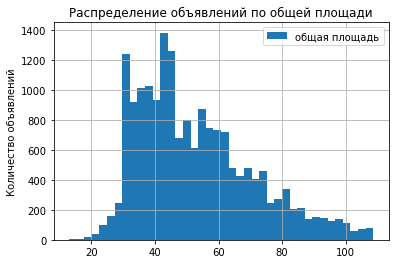

In [86]:
#Построим график распределения значений по столбцу общей площади без слишком больших и слишком малых значений
data_total_area = data[(data['total_area_too_much']==False) &(data['total_area_little']==False)]
data_total_area.plot(y = 'total_area', kind='hist',bins = 40, label='общая площадь', grid = True);
plt.title("Распределение объявлений по общей площади");
plt.ylabel("Количество объявлений");

Исследование общей площади недвижимости показало, что распределение значений не соответствует нормальному. Присутствует существенный перевес площадей в районе 30 кв.м. и от 41 до 45 кв.м., начиная с 60 кв.м начинается спад значений. 

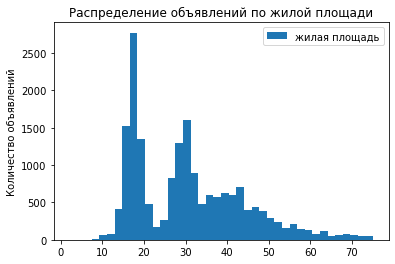

In [87]:
#Построим график распределения значений по столбцу жилая площадь без слишком больших и слишком малых значений
data_living_area = data[(data['living_area_too_much']==False) &(data['last_price_little']==False)]
data_living_area.plot(y = 'living_area', kind='hist', bins = 40, label='жилая площадь');
plt.title("Распределение объявлений по жилой площади");
plt.ylabel("Количество объявлений");

Распределение значений не соответствует нормальному. Наибольшее значение объявлений с жилой площадью от 18 до 20 кв.м, недвижимости с площадью 23-25 значительно ниже, чем в соседних диапазонах, второй пик объявлений приходится на 30 кв.м. +-3кв.м.Недвижимости с жилой площадью более 55 кв.м очень мало

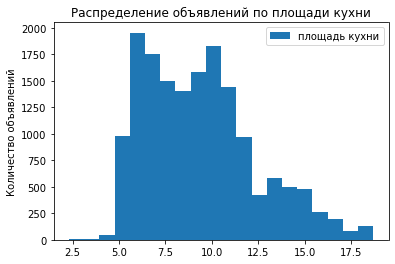

In [88]:
#Построим график распределения значений по столбцу площадь кухни без слишком больших и слишком малых значений
data_kitchen_area = data[(data['kitchen_area_too_much']==False) &(data['kitchen_area_little']==False)]
data_kitchen_area.plot(y ='kitchen_area', kind='hist', bins = 20, label='площадь кухни');
plt.title("Распределение объявлений по площади кухни");
plt.ylabel("Количество объявлений");

Распределение значений не соответствует нормальному. Максимальное количество объявлений с площадью кухонь около 6 и 10 кв.м

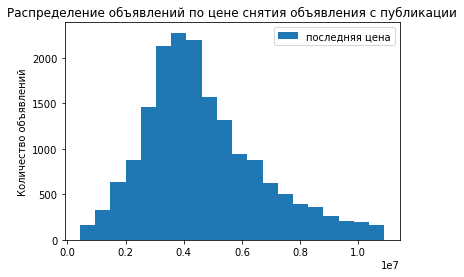

In [89]:
#Построим график распределения значений по столбцу цена продажи без слишком больших и слишком малых значений
data_last_price = data[(data['last_price_too_much']==False) &(data['last_price_little']==False)]
data_last_price.plot(y ='last_price', kind='hist', bins = 20, label='последняя цена');
plt.title("Распределение объявлений по цене снятия объявления с публикации");
plt.ylabel("Количество объявлений");

Распределение значений очень близко к нормальному. Большинство недвижимости находится в диапазоне от 3 до 5 млн.руб.

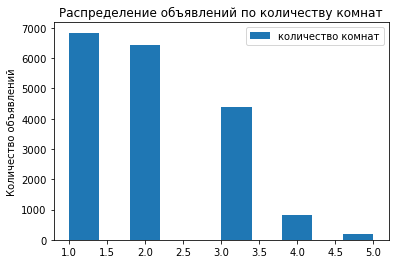

In [90]:
#Построим график распределения значений по столбцу количество комнат без слишком больших и слишком малых значений
data_rooms = data[(data['rooms_too_much']==False) &(data['rooms_little']==False)]
data_rooms.plot(y ='rooms', kind='hist', bins = 10, label='количество комнат');
plt.title("Распределение объявлений по количеству комнат");
plt.ylabel("Количество объявлений");

Среди предложений недвижимости, больше всего с 1 и 2 комнатами, с 3 комнатами чуть меньше

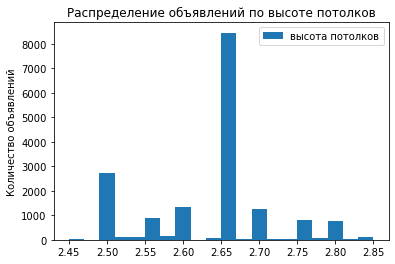

In [91]:
#Построим график распределения значений по столбцу высота потолков без слишком больших и слишком малых значений
data_ceiling_height = data[(data['ceiling_height_too_much']==False) &(data['ceiling_height_little']==False)]
data_ceiling_height.plot(y ='ceiling_height', kind='hist', bins = 20, label='высота потолков');
plt.title("Распределение объявлений по высоте потолков");
plt.ylabel("Количество объявлений");

Среди объявлений, основная масса недвижимости имеет значение 2,65м, на втором месте 2,5м

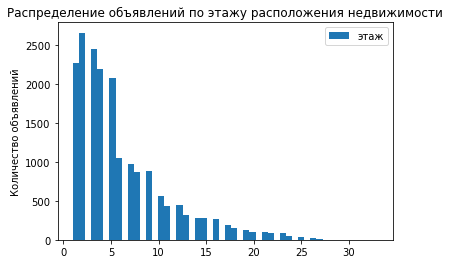

In [92]:
data.plot(y ='floor', kind='hist', bins = 50, label='этаж');
plt.title("Распределение объявлений по этажу расположения недвижимости");
plt.ylabel("Количество объявлений");

Больше всего предложений недвижимости на 1 и 2 этажах, более 5 этажа, предложений значительно меньше

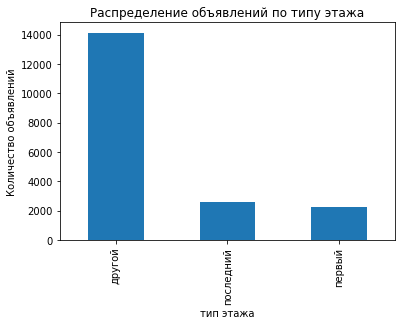

In [93]:
data['type_floor'].value_counts().plot(kind = 'bar', xlabel='тип этажа');
plt.title("Распределение объявлений по типу этажа");
plt.ylabel("Количество объявлений");

Недвижимости, расположенной на первом и последнем этажах меньше, чем на других

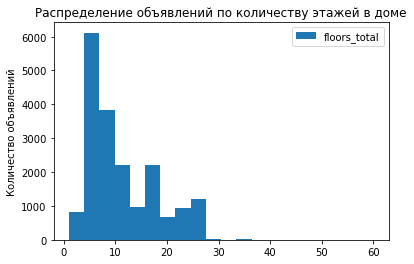

In [94]:
data.plot(y ='floors_total', kind='hist', bins = 20);
plt.title("Распределение объявлений по количеству этажей в доме");
plt.ylabel("Количество объявлений");

Можно сделать вывод, что большая часть недвижимости, выставленная на продажу, рсположена в домах не выше 5 этажей, на втором месте - 9-этажные строения.

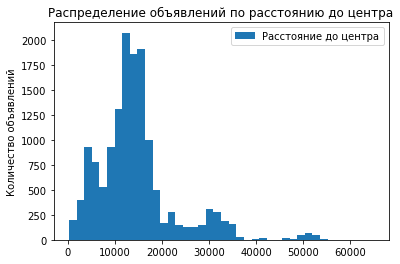

In [95]:
data_city_сenters_nearest = data[(data['city_сenters_nearest_too_much']==False) &(data['city_сenters_nearest_little']==False)]
data_city_сenters_nearest.plot(y ='city_сenters_nearest', kind='hist', bins = 40, label='Расстояние до центра');
plt.title("Распределение объявлений по расстоянию до центра");
plt.ylabel("Количество объявлений");

Основное количество предложениq, с указанным расстоянием до центра, расположено в пределах 20км от центра. 

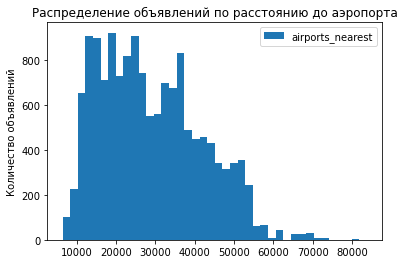

In [96]:
data_airports_nearest = data[(data['airports_nearest_too_much']==False) &(data['airports_nearest_little']==False)]
data_airports_nearest.plot(y ='airports_nearest', kind='hist', bins = 40);
plt.title("Распределение объявлений по расстоянию до аэропорта");
plt.ylabel("Количество объявлений");

Основное количество предложений располагаются в диапазоне от 10 до 45 км. от аэропорта

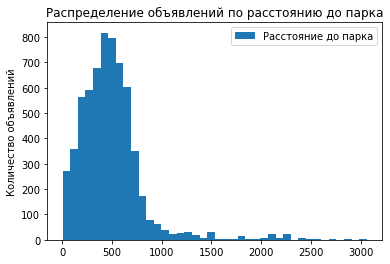

In [97]:
data_parks_nearest = data[(data['parks_nearest_too_much']==False) &(data['parks_nearest_little']==False)]
data_parks_nearest.plot(y ='parks_nearest', kind='hist', bins = 40, label='Расстояние до парка');
plt.title("Распределение объявлений по расстоянию до парка");
plt.ylabel("Количество объявлений");

In [98]:
data.groupby('parks_around_3000')['parks_around_3000'].count()

parks_around_3000
0    12647
1     4494
2     1356
3      481
Name: parks_around_3000, dtype: int64

Большая часть недвижимости, в параметрах которой указано расстояние до ближайшего парка, имеет парк в районе 500 м: 5131 - один парк, 1543 - 2 парка и всего 559 - 3 парка.

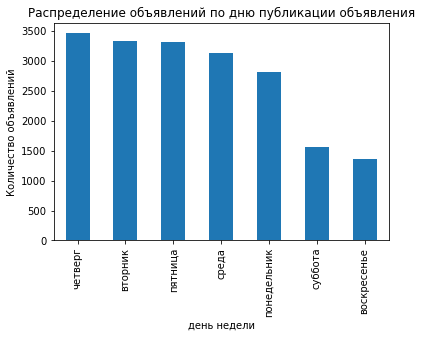

In [99]:
#день публикации объявления
data['weekday'].value_counts().plot(kind = 'bar', xlabel='день недели');
plt.title("Распределение объявлений по дню публикации объявления");
plt.ylabel("Количество объявлений");

Меньше всего объявлений, выставленных в субботу и воскресенье, больше всего объявлений, было выставлено в четверг, чуть меньше во вторник и пятницу

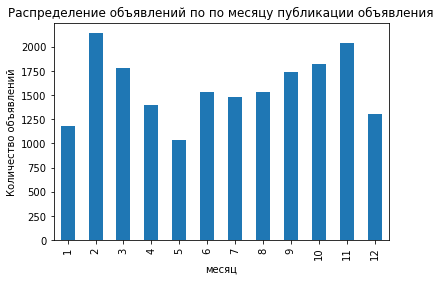

In [100]:
#Распределение объявлений по месяцу публикации объявления
plt.title("Распределение объявлений по по месяцу публикации объявления")
plt.ylabel("Количество объявлений");
data.groupby('month')['month'].count().plot(kind = 'bar', xlabel='месяц');

Больше всего предложений по времени размещения в феврале и марте, меньше всего в январе и мае

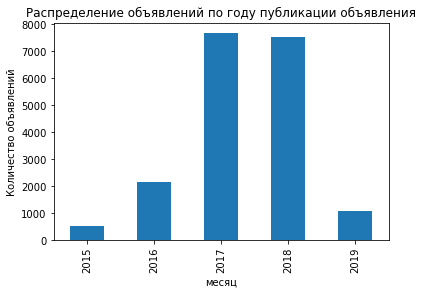

In [101]:
#Распределение объявлений по году публикации объявления
plt.title("Распределение объявлений по году публикации объявления")
plt.ylabel("Количество объявлений");
data.groupby('year')['year'].count().plot(kind = 'bar', xlabel='месяц');

Больше всего объявлений было в 2017 и 2018 гг. 

In [102]:
# Рассчитаем среднее значение и медиану времени, сколько объявление висело на сайте
display(data['days_exposition'].agg(['mean','median']))

mean      133.015808
median     86.000000
Name: days_exposition, dtype: float64

In [103]:
#Разобъем максимальное количество дней, которое объявление висело на сайте, на 18 равных групп, что соответствует примерно месяцу 
data['number_group_days_exposition'] = pd.cut(data['days_exposition'],18)

avg_days_exposition = data.groupby('number_group_days_exposition')['days_exposition'].agg(['mean','median', 'count'])

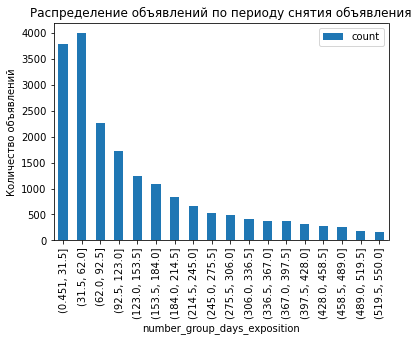

In [104]:
#Построим график количества объявления, снятых с продаж по группам
avg_days_exposition.plot(kind ='bar', y = 'count');
plt.title("Распределение объявлений по периоду снятия объявления");
plt.ylabel("Количество объявлений");

<div class="alert alert-block alert-info">
    
На графике хорошо видно, что квартиры чаще всего снимались с объявления (предположим, что продавались) в первый и второй месяц публикации, начиная с 3 месяца наблюдается существенное снижение. Среднее время продажи 133 дня, медианное 86. Продажи до 2 месяцев можно считать быстрыми продажами. Продажи свыше 550 дней - очень долгими.
    
</div>

### Подготовка данных для дальнейшего анализа, исключив из исходной таблицы выбросы по основным показателям

In [105]:
#Перезаписываем в новую таблицу данные, исключающие слишком большие и слишком малые значения
good_data = data[(data['total_area_too_much']==False) &(data['total_area_little']==False)&
                (data['living_area_too_much']==False) &(data['last_price_little']==False)&
                (data['kitchen_area_too_much']==False) &(data['kitchen_area_little']==False)&
                (data['last_price_too_much']==False) &(data['last_price_little']==False)&
                (data['rooms_too_much']==False) &(data['rooms_little']==False)&
                (data['ceiling_height_too_much']==False) &(data['ceiling_height_little']==False)
                ]

In [106]:
#Оценим количество строк, оставшихся после обработки значений
good_data.shape

(15536, 54)

После удаления пропущенных значений и обработки данных осталось 15536 строк, что составляет 65,55%

In [107]:
#Оставим столбцы, с основными показателями стоимости
basic_good_data = data[['last_price',
                                   'total_area',
                                   'living_area',
                                   'kitchen_area',
                                   'type_floor',
                                   'rooms',
                                   'ceiling_height', 
                                   'days_exposition',
                                   'city_сenters_nearest',
                                   ]]

#### Рассмотрим зависимость цены недвижимости от ключевых факторов

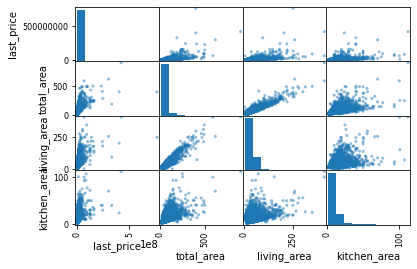

In [108]:
basic_good_data_main_corr = basic_good_data[['last_price',
                 'total_area',
                 'living_area',
                 'kitchen_area']
]
pd. plotting.scatter_matrix(basic_good_data_main_corr);

Наиболее сильная связь наблюдается между общей и жилой площадью, между общей площадью и ценой, ценой и жилой площадью, ценой и площадью кухни остальные факторы более "размыты"

In [109]:
#Рассмотрим ключевые статистические показатели факторов, на наш взгляд, которые могут оказывать влияние на цену недвижимости
basic_good_data[['last_price',
                 'total_area',
                 'living_area',
                 'kitchen_area',
                 'rooms',
                 'type_floor',
                 'days_exposition',
                 'city_сenters_nearest']
].describe().round()

,last_price,total_area,living_area,kitchen_area,rooms,days_exposition,city_сenters_nearest
count,18978.0,18978.0,18871.0,17053.0,18978.0,18978.0,18978.0
mean,6107969.0,58.0,33.0,10.0,2.0,133.0,26211.0
std,10754260.0,33.0,20.0,6.0,1.0,128.0,22891.0
min,12190.0,12.0,2.0,2.0,0.0,1.0,208.0
25%,3390000.0,39.0,18.0,7.0,1.0,42.0,11198.0
50%,4500000.0,50.0,30.0,9.0,2.0,86.0,15043.0
75%,6400000.0,67.0,41.0,12.0,3.0,188.0,34247.0
max,763000000.0,900.0,410.0,112.0,19.0,550.0,65968.0


Анализ показал, что средняя цена снятия объявления 4,5 млн., средняя общя площадь 51 кв.м.(медианное значение - 47 кв.м.), жилая площадь - 29 кв.м.(28 кв.м. - медианное значение), площадь кухни - 9 кв.м., количество комнат - 2-х комнатные, среднее время размещения - 133 дня, среднее расстояние от центра 29 км (медианное - 16 км).

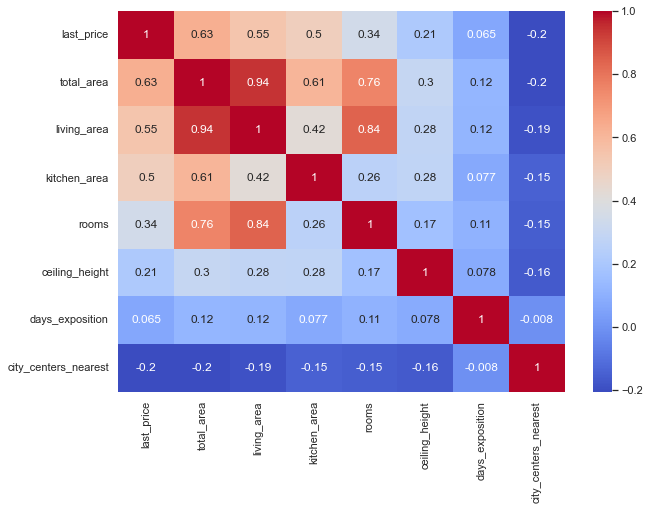

In [110]:
sns.set(rc = {'figure.figsize':(10,7)})
sns.heatmap(basic_good_data.corr(), cmap= 'coolwarm', annot = True);

Наиболее сильная зависимость имеется между ценой недвижимости и общей площадью (0.661460), чуть меньше - обратная зависимость между расстоянием до центра (-0.539832). Так же оказывают сильное влияние по отдельности жилая площадь и площадь кухни. Значимый коэффициент корреляции Пирсона между ценой и площадью кухни говорит о том, что недвижимость с большей площадью имеют большую стоимость. Высота потолков и количество дней объявления практически не оказывают никакого влияния на цену. При этом, надо отметить, что существует зависимость между площадью кухни и высотой потолков, что говорит о том, что объекты недвижимости имеют стандартную планировку. Количество комнат напрямую зависит от жилой и общей площади, что подтверждает вывод про стандартную планировку объектов. 

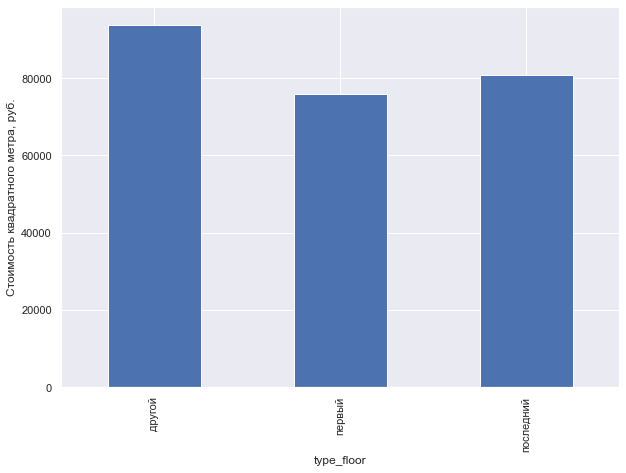

In [111]:
# Определим среднюю стоимость 1 квадратного метра в зависимости от этажа 
good_data.groupby('type_floor')['cost_per_square_meter'].mean().plot(kind = 'bar', x = 'type_floor', y = 'cost_per_square_meter');
plt.ylabel("Стоимость квадратного метра, руб.");

Стоимость недвижимости зависит от типа этажа. Так, средняя стоимость 1 кв.м. на первом этаже составляет 76132 руб, на последнем, 80342 руб, на других этажах - 94461 руб.

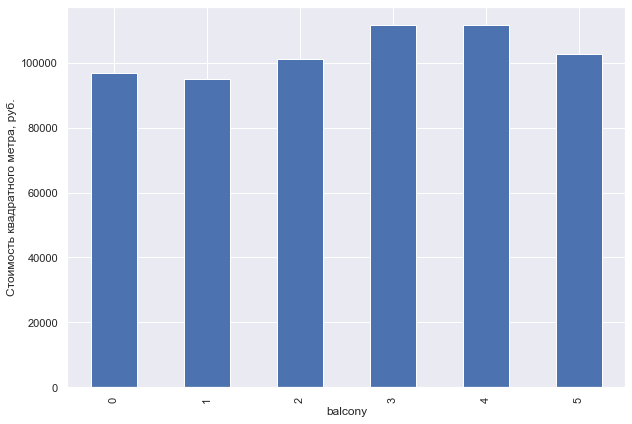

In [112]:
#Определим среднюю стоимость 1 квадратного метра в зависимости от наличия балкона 
data.groupby('balcony')['cost_per_square_meter'].mean().plot(kind = 'bar', x = 'type_floor', y = 'cost_per_square_meter');
plt.ylabel("Стоимость квадратного метра, руб.");

График показывает, что существенного влияния на стоимость 1 кв.м. недвижимости количество балконов практически не влияет, цена немного выше при 3 и 4 балконах.

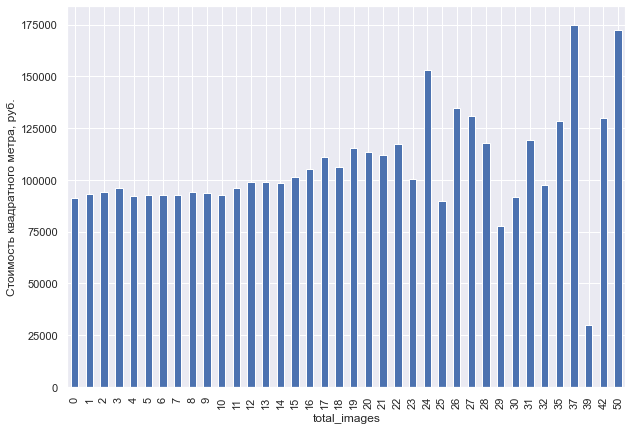

In [113]:
#Определим среднюю стоимость 1 квадратного метра и количество фотографий
data.groupby('total_images')['cost_per_square_meter'].mean().plot(kind = 'bar', x = 'type_floor', y = 'cost_per_square_meter');
plt.ylabel("Стоимость квадратного метра, руб.");

Можно заключить, что у недвижимости, у которой цена за 1 кв.м выше, больше фотографий на сайте

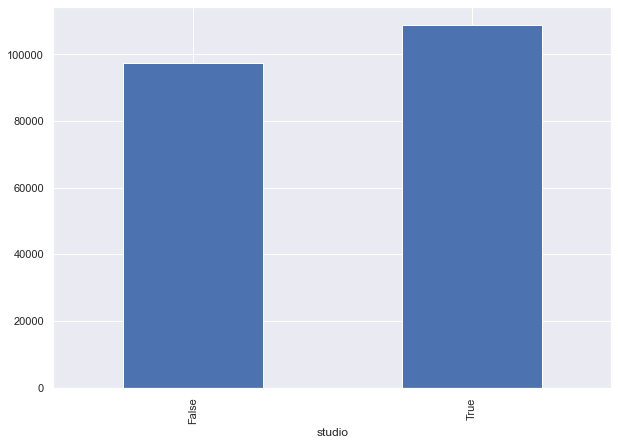

In [114]:
#Определим среднюю стоимость 1 квадратного метра у студии
data.groupby('studio')['cost_per_square_meter'].mean().plot(kind = 'bar', x = 'studio', y = 'cost_per_square_meter');

Квадратный метр студии в среднем дороже, чем у других видов недвижимости

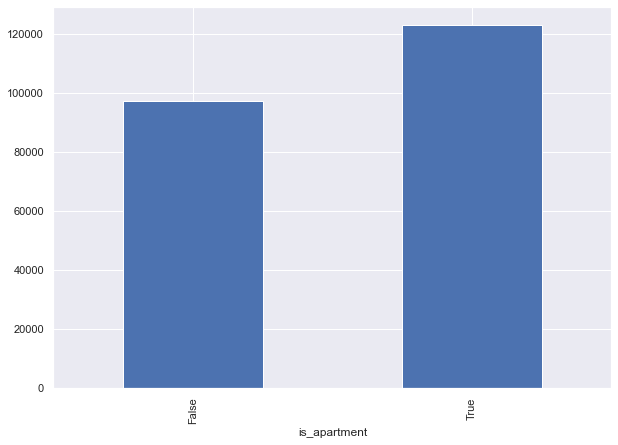

In [115]:
#Определим среднюю стоимость 1 квадратного метра в апартаментах
data.groupby('is_apartment')['cost_per_square_meter'].mean().plot(kind = 'bar', x = 'is_apartment', y = 'cost_per_square_meter');

Квадратный метр апартаментов в среднем дороже, чем у других видов недвижимости

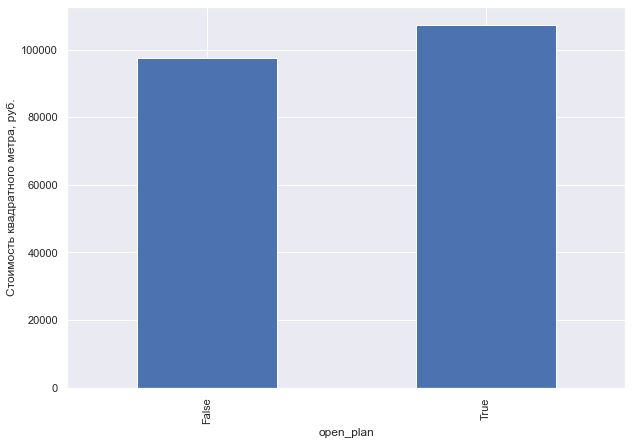

In [116]:
#Определим среднюю стоимость 1 квадратного метра недвижимости со свободной планировкой
data.groupby('open_plan')['cost_per_square_meter'].mean().plot(kind = 'bar', x = 'type_floor', y = 'cost_per_square_meter');
plt.ylabel("Стоимость квадратного метра, руб.");

Квадратный метр недвижимости со свободной планировкой в среднем дороже, чем у других видов недвижимости

In [117]:
#выберем 10 населенных пунктов с большим количеством объявлений и рассчитаем в них цены за квадратный метр
top_10_price_meter = good_data.pivot_table(index='locality_name', values='cost_per_square_meter', aggfunc=['count','median', 'mean'])
top_10_price_meter.columns = ['count', 'median', 'mean']
top_10_price_meter = top_10_price_meter.sort_values('count', ascending=False).round().head(10)
top_10_price_meter.sort_values('mean', ascending=False)

,count,median,mean
locality_name,,,
Санкт-Петербург,9638,100000.0,102959.0
Пушкин,228,96877.0,98116.0
Кудрово,365,95522.0,94757.0
поселок Парголово,281,91328.0,89484.0
поселок Мурино,483,84726.0,85287.0
поселок Шушары,375,75758.0,77461.0
Колпино,274,74005.0,74748.0
Гатчина,229,66667.0,67885.0
Всеволожск,287,65083.0,66417.0


Самый дорогой квадратный метр в г.Санкт-Петербурге (104381) и г.Пушкин (99166.), на третьем месте - г. Кудрово (95516), самый дешевый квадратный метр в г.Выборге, г. Всеволожск и г.Гатчина (57641, 66805, 68404 соответственно)

In [118]:
#Рассмотрим связь между ценой и расстоянием до центра, парков, водоемой  аэропорта по таблице с обработанными данными
corr_cost_m_nearest = data[['cost_per_square_meter','airports_nearest','city_сenters_nearest', 'parks_nearest','ponds_nearest']]
corr_cost_m_nearest.corr()

,cost_per_square_meter,airports_nearest,city_сenters_nearest,parks_nearest,ponds_nearest
cost_per_square_meter,1.000000,-0.374355,-0.469070,-0.263997,-0.262968
airports_nearest,-0.374355,1.000000,0.888071,0.341104,0.384867
city_сenters_nearest,-0.469070,0.888071,1.000000,0.409097,0.383790
parks_nearest,-0.263997,0.341104,0.409097,1.000000,0.303099
ponds_nearest,-0.262968,0.384867,0.383790,0.303099,1.000000


Стоимость квадратного метра довольно сильно зависит от близости расположения к центру, чуть меньше от расположения аэропорта. Влияние расстояния до парков и водоемов одинаковое

Так как в ходе предобработки данных, некоторые пропуски были заполнены максимальным значением, определим как это повлияло на значимость этих факторов в определении цены недвижимости

In [119]:
#Рассмотрим связь между ценой и расстоянием до центра, парков, водоемой  аэропорта по исходной таблице 
df['cost_per_square_meter'] = df['last_price']/df['total_area']
corr_cost_m_nearest1 = df[['cost_per_square_meter','airports_nearest','cityCenters_nearest', 'parks_nearest','ponds_nearest']]
corr_cost_m_nearest1.corr()

,cost_per_square_meter,airports_nearest,cityCenters_nearest,parks_nearest,ponds_nearest
cost_per_square_meter,1.000000,-0.038734,-0.317951,0.006933,-0.104974
airports_nearest,-0.038734,1.000000,0.272184,-0.070058,0.014049
cityCenters_nearest,-0.317951,0.272184,1.000000,-0.040650,0.028903
parks_nearest,0.006933,-0.070058,-0.040650,1.000000,0.000692
ponds_nearest,-0.104974,0.014049,0.028903,0.000692,1.000000


Оценка влияния факторов расстояния дот центра, парков, водоемов и аэропорта по исходным данным показало незначительное влияние расстояния до центра, влияние остальных факторов отсутствует

Таким образом, больше всего на цену недвижимости влияет общая и жилая площади, количество комнат (но они имеют зависимость с общей и жилой площадью), площадь кухни, чуть меньше: количество балконов, тип этажа, вид недвижимости:апартаменты, студия, свободная или нет планировка, локация, удаленность от центра

### Исследование, как стоимость объектов зависит от расстояния до центра города на примере г.Санкт-Петербург.

Рассмотрим предложения в г. Санкт-Петербург более подробно

,mean,median,count
city_center_km_group,,,
"(0.333, 5.443]",6.905336e+06,6900000.0,563
"(5.443, 10.487]",5.543089e+06,5000000.0,1477
"(10.487, 15.53]",5.076036e+06,4690000.0,5261
"(15.53, 20.574]",4.737949e+06,4442500.0,1940
"(20.574, 25.618]",4.681420e+06,4400000.0,342
"(25.618, 30.662]",4.117911e+06,3650000.0,41
"(30.662, 35.705]",NaN,NaN,0
"(35.705, 40.749]",NaN,NaN,0
"(40.749, 45.793]",NaN,NaN,0


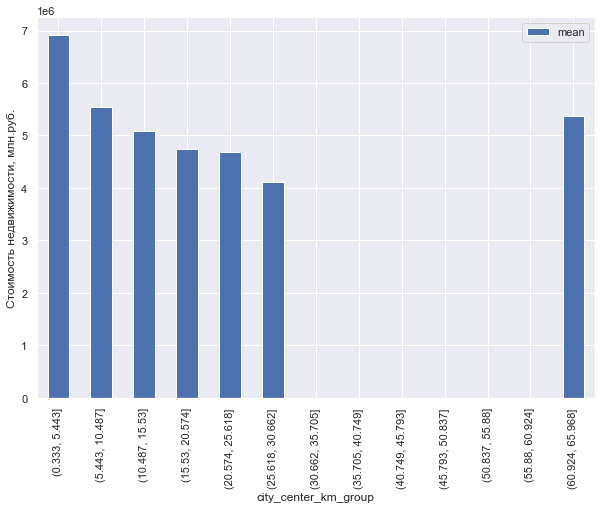

In [120]:
#Выберем недвижимость, расположенную только в Санкт-Петербурге
spb_data = good_data.query('locality_name=="Санкт-Петербург"' ).copy()
#Определим максимальное значение имеющихся данных, чтобы понимать, на какое число групп разбить данные
spb_data['city_center_km'].max()
#Разобъем расстояние до центра города на 13 групп - примерно по 5 км
spb_data['city_center_km_group'] = pd.cut(spb_data['city_center_km'], 13)
#Определим среднее и  медианное значение стоимости в каждой группе
avg_cost_km = spb_data.groupby('city_center_km_group')['last_price'].agg(['mean','median', 'count'])
display(avg_cost_km)
#Изобразим графически полученные значения
avg_cost_km.plot(kind ='bar', y = 'mean');
plt.ylabel("Стоимость недвижимости, млн.руб.");

На рисунке хорошо видно, что стоимость недвижимости чем ближе к центру, тем выше, так, в районе 5 км от центра - средняя стоимость недвижимости составляет 7 млн. рублей, от 5 км до 10 км - 5,65 млн. рублей, от 10 км до 15 км - 5,21 млн. рублей, от 15 км до 20 км - 4,87 млн., от 20 км до 25 км - 4,81 млн., от 25 до 30 км - 4,23 млн. Пропущенные значения мы заполняли максимальным, в связи с чем, в последнюю группу попало больше всего объектов, расположенных от центра далее 60 км (в этой группе средняя цена недвижимости составляет 6,34 млн.) в самом центре предложений очень мало - всего 574, наибольшее количество предложений сосредоточено в группе с расстоянием от 10 до 15 км.

In [121]:
#Определим среднее значение 1 кв.м. относительно расположения от центра
avg_cost_km_1m = spb_data.groupby('city_center_km_group')['cost_per_square_meter'].agg(['mean','median', 'count']).round()
avg_cost_km_1m

,mean,median,count
city_center_km_group,,,
"(0.333, 5.443]",118061.0,112308.0,563
"(5.443, 10.487]",110932.0,106501.0,1477
"(10.487, 15.53]",102679.0,100593.0,5261
"(15.53, 20.574]",95988.0,94745.0,1940
"(20.574, 25.618]",89002.0,87500.0,342
"(25.618, 30.662]",86722.0,86200.0,41
"(30.662, 35.705]",NaN,NaN,0
"(35.705, 40.749]",NaN,NaN,0
"(40.749, 45.793]",NaN,NaN,0


Подтвердился наш вывод о том, что чем ближе к центру, тем дороже. В самом центре стоимость 1 кв.м. недвижимости составляет 119350 руб, от 5 до 11 км - 112375 руб, от 10 до 15 - 104157 рублей.

Рассмотрим показатели соотношения стоимости 1 кв м от расстояния от центра без учета заполненных максимальным значением данных (за анализ возьмем исходную таблицу)

In [122]:
#Выберем недвижимость, расположенную только в Санкт-Петербурге
spb_data_new = df.query('locality_name=="Санкт-Петербург"').copy()
spb_data_new['cost_per_square_meter'] = spb_data_new['last_price']/spb_data_new['total_area']
#Разобъем расстояние до центра города на 6 групп
spb_data_new['city_center_km_group'] = pd.cut(spb_data_new['cityCenters_nearest'], 6)
#Определим среднее значение 1 кв.м. относительно расположения от центра
avg_cost_km_1m2 = spb_data_new.groupby('city_center_km_group')['cost_per_square_meter'].agg(['mean','median', 'count']).round()
avg_cost_km_1m2

,mean,median,count
city_center_km_group,,,
"(151.688, 5066.333]",142251.0,121210.0,2150
"(5066.333, 9951.667]",132748.0,117143.0,2892
"(9951.667, 14837.0]",107630.0,103919.0,6502
"(14837.0, 19722.333]",99738.0,96970.0,3553
"(19722.333, 24607.667]",93195.0,89965.0,469
"(24607.667, 29493.0]",89171.0,89141.0,94


Проведенный анализ показал, что в ходе предобработки данных, были допущены ошибки, связанные с заполнением пропущенных значений. Так, напрмер, стоиомсть 1 кв.м. в Санкт-Петербурге до 5 км от центра составляет 142251 руб, от 5 до 10 км - 132748 руб., от 10 до 15 - 107630 руб. В первых двух группах отличие цены составляет 18-19%, в остальных меньше.

In [123]:
#Рассчитаем корреляцию стоимости от расстояния по исходным данным
corr_base_date = df[['last_price', 'cityCenters_nearest']]
corr_base_date.corr()

,last_price,cityCenters_nearest
last_price,1.000000,-0.206747
cityCenters_nearest,-0.206747,1.000000


Полученные данные коэффициента Пирсона не сильно расходятся от обработанных данных (-0.206747 против -0.22), что может свидетельствовать о том, что при предобработке данных хоть и был выбран не лучший способ заполнения пропусков, на общую картину особого влияния это не оказало.

### Общий вывод

Общий вывод по проекту: <b>«Исследование объявлений о продаже квартир»</b>. Проект выполнялся с целью установления параметров, влияющих на рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
Входные данные - данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 
Предварительная оценка данных показала, что распределения значений по факторам не соответствует нормальному (имеются выбросы), в данных имеются пропуски, тип данных требует корректировки. 
<p>Пропущенные значения были устранены следующим образом:. <p>"ceiling_height" - сравнили 2 варианта заполнения и выбрали оптимальный: заполнили медианным значением по столбцу  <p>"floors_total" - исключили из исследования <p>"living_area" - заполнили пропуски медианным значением, в зависимости от количество комнат <p>"is_apartment" - значением False<p>"kitchen_area" - проверили 2 теории: заполнили медианным значением относительно общей площади <p>"balcony" – заполнили значением 0 <p>"locality_name" - на значение 'неизвестно'<p>"airports_nearest" - заполнили максимальным значением <p>"city_сenters_nearest" - заполнили максимальным значением <p>"parks_around_3000" - заполнили значением 0 <p>"parks_nearest" – максимальным значением<p>"ponds_around_3000" - значением 0 <p>"ponds_nearest"- заполнили максимальным значением <p>"days_exposition" - оставили пропуски.
<p>Природа пропусков различна: часть из них, скорее всего не была указана пользователем, а часть, мы предполагаем, имеют технический характер.
<p>Столбцы 'last_price', 'floors_total', 'balcony', 'parks_around_3000', 'ponds_around_3000', 'days_exposition' были приведены в целочисленный тип данных, столбец 'is_apartment' – в булевый, столбец 'first_day_exposition' – к типу даты. В столбцах: общая площадь, высота потолков, жилая площадь и площадь кухни тип данных был изменен на float32 для экономии памяти.
Были выявлены и устранены неявные дубликаты : 'посёлок' и 'поселок', 'городской поселок' и 'поселок городского типа', 'садоводческое некоммерческое товарищество' и 'садовое товарищество', 'деревня Кудрово' и 'Кудрово', 'посeлок Мурино' и 'Мурино'.
<p>Аномальные значения в столбце 'ceiling_height' (более 20 м) были разделены на 10 (считаем, что это опечатка при вводе), для соответствия более реальным данным.
<p>По столбцу 'days_exposition' значения больше 550 были отброшены.
<p>Создали новые столбцы со слишком дорогой и слишком дешевой недвижимостью, со слишком большой и слишком малой жилой площадью недвижимостью, со слишком большой и слишком малой общей площадью недвижимостью, со слишком высокими и слишком низкими потолками, со слишком большим и слишком малым числом комнат, со слишком большой и слишком малой площадью кухни, со слишком далеким и слишком близким расположением от аэропорта, со слишком далеким и слишком близким расположением от центра, со слишком далеким и слишком близким расположением от парка, со слишком далеким и слишком близким расположением от водоема.
<p>Добавили столбцы дня недели, месяца и года.
<p>Добавили столбец с типом этажа: с типом этажа: "первый", "последний", "другой".
<p>Добавили столбец с расстоянием в км до центра города.
<p>Исследование общей площади недвижимости показало, что распределение значений не соответствует нормальному. Присутствует существенный перевес площадей в районе 30 кв.м. и от 41 до 45 кв.м., начиная с 60 кв.м начинается спад значений.
Наибольшее значение объявлений с жилой площадью от 18 до 20 кв.м, недвижимости с площадью 23-25 значительно ниже, чем в соседних диапазонах, второй пик объявлений приходится на 30 кв.м. +-3кв.м.Недвижимости с жилой площадью более 55 кв.м очень мало.
<p>Максимальное количество объявлений с площадью кухонь около 6 и 10 кв.м. Большинство недвижимости находится в диапазоне от 3 до 5 млн.руб. Среди предложений недвижимости, больше всего с 1 и 2 комнатами, с 3 комнатами чуть меньше.Основная масса недвижимости имеет значение высоты потолка 2,65м, на втором месте 2,5м. Больше всего предложений недвижимости на 1 и 2 этажах, более 5 этажа, предложений значительно меньше. Недвижимости, расположенной на первом и последнем этажах меньше, чем на других. 
Большая часть недвижимости, выставленная на продажу, расположена в домах не выше 5 этажей, на втором месте - 9-этажные строения. Основное количество предложений, с указанным расстоянием до центра, расположено в пределах 20км от центра. 
Основное количество предложений располагаются в диапазоне от 10 до 45 км. от аэропорта. Большая часть недвижимости, в параметрах которой указано расстояние до ближайшего парка, имеет парк в районе 500 м: 5131 - один парк, 1543 - 2 парка и всего 559 - 3 парка.Меньше всего объявлений, выставленных в субботу и воскресенье, больше всего объявлений, было выставлено в четверг, чуть меньше во вторник и пятницу. Больше всего предложений по времени размещения в феврале и марте, меньше всего в январе и мае. Больше всего объявлений было в 2017 и 2018 гг. Квартиры чаще всего снимались с объявления (предположим, что продавались) в первый и второй месяц публикации, начиная с 3 месяца наблюдается существенное снижение. Среднее время продажи 133 дня, медианное 86. Продажи до 2 месяцев можно считать быстрыми продажами. Продажи свыше 550 дней - очень долгими.
<p>После удаления пропущенных значений и обработки данных осталось 15536 строк, что составляет 65,55%
<p>Анализ показал, что средняя цена снятия объявления 4,5 млн., средняя общя площадь 51 кв.м.(медианное значение - 47 кв.м.), жилая площадь - 29 кв.м.(28 кв.м. - медианное значение), площадь кухни - 9 кв.м., количество комнат - 2-х комнатные, среднее время размещения - 133 дня, среднее расстояние от центра 29 км (медианное - 16 км).
<p>Наиболее сильная зависимость имеется между ценой недвижимости и общей площадью (0.661460), чуть меньше - обратная зависимость между расстоянием до центра (-0.539832). Так же оказывают сильное влияние по отдельности жилая площадь и площадь кухни. Значимый коэффициент корреляции Пирсона между ценой и площадью кухни говорит о том, что недвижимость с большей площадью имеют большую стоимость. Высота потолков и количество дней объявления практически не оказывают никакого влияния на цену. При этом, надо отметить, что существует зависимость между площадью кухни и высотой потолков, что говорит о том, что объекты недвижимости имеют стандартную планировку. Количество комнат с жилой и общей площадью имеют прямую корреляцию, что подтверждает вывод про стандартную планировку объектов.
<p>Стоимость недвижимости зависит от типа этажа. Так, средняя стоимость 1 кв.м. на первом этаже составляет 76132 руб, на последнем, 80342 руб, на других этажах - 94461 руб.Существенного влияния на стоимость 1 кв.м. недвижимости количество балконов практически не влияет, цена немного выше при 3 и 4 балконах. Квадратный метр студии, аппартаметов и недвижимости со свободной планировкой в среднем дороже, чем у других видов недвижимости. Оценка влияния факторов расстояния дот центра, парков, водоемов и аэропорта по исходным данным показало незначительное влияние расстояния до центра, влияние остальных факторов отсутствует.  
<p>Среди 10 населенных пунктов с большим количеством объявлений самый дорогой квадратный метр в г.Санкт-Петербурге (104381) и г.Пушкин (99166.), на третьем месте - г. Кудрово (95516), самый дешевый квадратный метр в г.Выборге, г. Всеволожск и г.Гатчина (57641, 66805, 68404 соответственно).
<p>Исследование, как стоимость объектов зависит от расстояния до центра города по г. Санкт-Петербург показало, что стоимость недвижимости чем ближе к центру, тем выше, так, в районе 5 км от центра - средняя стоимость недвижимости составляет 7 млн. рублей, от 5 км до 10 км - 5,65 млн. рублей, от 10 км до 15 км - 5,21 млн. рублей, от 15 км до 20 км - 4,87 млн., от 20 км до 25 км - 4,81 млн., от 25 до 30 км - 4,23 млн., в самом центре предложений очень мало - всего 574, наибольшее количество предложений сосредоточено в группе с расстоянием от 10 до 15 км. В самом центре стоимость 1 кв.м. недвижимости составляет 119350 руб, от 5 до 11 км - 112375 руб, от 10 до 15 - 104157 рублей.
<p>Таким образом, больше всего на цену недвижимости влияет общая и жилая площади, количество комнат, площадь кухни (но они имеют зависимость с общей и жилой площадью), чуть меньше: количество балконов, тип этажа, вид недвижимости:апартаменты, студия, свободная или нет планировка, локация, удаленность от центра. 

Рекомендации по сбору данных - определить причину пропусков по столбцам с расстояниями (скорее всего они расставляются автоматически, исходя из геопозиции, а не пользователем), добавить данные по типу недвижимости - старый или новый жилой фонд (год постройки), с ремонтом или без него, квартира или частный дом (так как, например, есть двухэтажные многоквартирные дома, а также трехэтажные и более частные дома).
